# Analysing predicted poses for EPM (Practical 2)

This notebook analyses predicted poses for a single mouse performing an elevated plus maze (EPM) task.

It first imports predicted poses from either [SLEAP](https://sleap.ai) or [DeepLabCut](https://www.mackenziemathislab.org/deeplabcut) using [movement](https://movement.neuroinformatics.dev/).

Subsequently, the following operations are performed on predicted poses:
- plotting of trajectories and confidence scores
- filtering to exclude low-confidence points and outliers and to smooth the trajectories.
- computing of time-spent in different parts of the maze

## A. Setup
### A1. Create a conda environment and install required packages

In a terminal, clone the repository and go to the `notebooks` directory:
```bash
git clone https://github.com/neuroinformatics-unit/course-behavioural-analysis-2023.git
cd course-behavioural-analysis-2023/notebooks
```

Create a new conda environment and install required packages:
```bash
conda create -n practical2 -c conda-forge python=3.10 pytables
conda activate practical2
pip install -r practical2_requirements.txt
```

Once all requirements are installed, you can open this notebook and select the `practical2` kernel.

### A2. Import required packages

In [58]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import xarray as xr

from movement.io import load_poses

### A3. Specify paths to data

You should modify `DATA_DIR` to point to the directory where you downloaded the `mouse-EPM` folder containing the sample data.

The `derivatives` subfolder contains predictions from both SLEAP and DeepLabCut.
```bash
.
├── derivatives
│   └── behav
│       ├── software-DLC_predictions
│       └── software-SLEAP_project
│           └── predictions
│
└── rawdata
    ├── sub-01_id-M708149
    │   └── ses-01_date-20200317
    └── sub-02_id-M708154
        └── ses-01_date-20200317
```

- The SLEAP predictions were generated by Niko Sirmpilatze, based on only a few training examples.
- The DeepLabCut predictions were generated by Loukia Katsouri and should be of higher quality than the SLEAP predictions.

In [59]:
DATA_DIR = Path.home() / "Data" / "behav-analysis-course" / "mouse-EPM"
behav_deriv_dir = DATA_DIR / "derivatives" / "behav"

# SLEAP predictions
sleap_predictions_dir = behav_deriv_dir / "software-SLEAP_project" / "predictions"
video1_sleap_preds_file = sleap_predictions_dir / "video-1.predictions.analysis.h5"
video2_sleap_preds_file = sleap_predictions_dir / "video-2.predictions.analysis.h5"

# DeepLabCut predictions
dlc_predictions_dir = behav_deriv_dir / "software-DLC_predictions"
video1_dlc_preds_file = dlc_predictions_dir / "sub-01_ses-01_task-EPM_time-165049_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000_filtered.h5"
video2_dlc_preds_file = dlc_predictions_dir / "sub-02_ses-01_task-EPM_time-185651_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000_filtered.h5"

# Frames (used as background for plotting)
video1_frame_file = dlc_predictions_dir / "sub-01_ses-01_task-EPM_time-170049_frame.png"
video2_frame_file = dlc_predictions_dir / "sub-02_ses-01_task-EPM_time-190651_frame.png"

**Optional:** check that the above paths are correct by running the following cell:

In [60]:
for folder in [behav_deriv_dir, sleap_predictions_dir, dlc_predictions_dir]:
    assert folder.is_dir()

for file in [
    video1_sleap_preds_file,
    video2_sleap_preds_file,
    video1_dlc_preds_file,
    video2_dlc_preds_file,
    video1_frame_file,
    video2_frame_file,
]:
    assert file.is_file()

## B. Load and explore predictions
### B1. Loading predictions with `movement`
The pose tracks and the associated point-wise confidence scores are imported using [`movement`]((https://movement.neuroinformatics.dev/)) and represented as [xarray.Dataset](https://movement.neuroinformatics.dev/getting_started.html#dataset-structure) objects.

In [61]:
ds_sleap_video1 = load_poses.from_sleap_file(video1_sleap_preds_file, fps=30)
ds_sleap_video1

<xarray.Dataset>
Dimensions:      (time: 18485, individuals: 1, keypoints: 6, space: 2)
Coordinates:
  * time         (time) float64 0.0 0.03333 0.06667 0.1 ... 616.1 616.1 616.1
  * individuals  (individuals) <U12 'individual_0'
  * keypoints    (keypoints) <U9 'snout' 'left_ear' ... 'tail_base' 'tail_end'
  * space        (space) <U1 'x' 'y'
Data variables:
    pose_tracks  (time, individuals, keypoints, space) float32 nan nan ... 476.2
    confidence   (time, individuals, keypoints) float32 nan nan ... 0.7607
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      /Users/nsirmpilatze/Data/behav-analysis-course/mouse-EP...

**Exercise 1:**

- Load the DeepLabCut predictions for video1 (`sub-01`) into a `ds_dlc_video1` variable.

- Do you notice any differences between the SLEAP and DeepLabCut predictions?

**Hint:** consult the [Loading data](https://movement.neuroinformatics.dev/getting_started.html#loading-data) section of the `movement` documentation.

In [15]:
# Write your code here

In [62]:
# Solution
ds_dlc_video1 = load_poses.from_dlc_file(video1_dlc_preds_file, fps=30)
ds_dlc_video1

<xarray.Dataset>
Dimensions:      (time: 18485, individuals: 1, keypoints: 8, space: 2)
Coordinates:
  * time         (time) float64 0.0 0.03333 0.06667 0.1 ... 616.1 616.1 616.1
  * individuals  (individuals) <U12 'individual_0'
  * keypoints    (keypoints) <U13 'snout' 'left_ear' ... 'tailbase' 'tail_end'
  * space        (space) <U1 'x' 'y'
Data variables:
    pose_tracks  (time, individuals, keypoints, space) float64 508.3 ... 390.2
    confidence   (time, individuals, keypoints) float64 0.0002829 ... 0.9978
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  DeepLabCut
    source_file:      /Users/nsirmpilatze/Data/behav-analysis-course/mouse-EP...

Check that your solution is correct by running the following cell:

In [63]:
assert isinstance(ds_dlc_video1, xr.Dataset), "ds_dlc_video1 should exist and be an xarray Dataset"
assert ds_dlc_video1.source_software == "DeepLabCut", "ds_dlc_video1 should have source_software='DeepLabCut'"

### B2. Selecting subsets of the data
Below we get the "pose tracks" data variable for 3 keypoints: "snout", "centre", "tail_base"

In [64]:
pose_tracks_sleap_3kps = ds_sleap_video1.pose_tracks.sel(keypoints=["snout", "centre", "tail_base"])
pose_tracks_sleap_3kps

<xarray.DataArray 'pose_tracks' (time: 18485, individuals: 1, keypoints: 3,
                                 space: 2)>
nan nan nan nan nan nan nan nan ... 384.0 684.7 504.8 667.8 440.0 636.8 384.1
Coordinates:
  * time         (time) float64 0.0 0.03333 0.06667 0.1 ... 616.1 616.1 616.1
  * individuals  (individuals) <U12 'individual_0'
  * keypoints    (keypoints) <U9 'snout' 'centre' 'tail_base'
  * space        (space) <U1 'x' 'y'

**Exercise 2:**

- Work with the `ds_dlc_video1` dataset you created in **Exercise 1**.

- Get the `confidence` data values for the `snout` keypoint, between time 2 and 4 minutes (inclusive), and store them in a variable called `snout_confidence`.

**Hint:** Consult the [Indexing and selection](https://movement.neuroinformatics.dev/getting_started.html#indexing-and-selection) section of the `movement` documentation.

In [13]:
# Write your code here


In [65]:
# Solution
snout_confidence = ds_dlc_video1.confidence.sel(keypoints="snout", time=slice(2 * 60, 4 * 60))
snout_confidence

<xarray.DataArray 'confidence' (time: 3601, individuals: 1)>
0.9989 0.9998 0.9998 0.9998 0.9997 0.9995 ... 0.9419 0.9743 0.9883 0.9985 0.9992
Coordinates:
  * time         (time) float64 120.0 120.0 120.1 120.1 ... 239.9 240.0 240.0
  * individuals  (individuals) <U12 'individual_0'
    keypoints    <U13 'snout'

Check if your solution is correct by running the following cell:

In [66]:
assert isinstance(snout_confidence, xr.DataArray), "snout_confidence should exist and be an xarray DataArray"
assert snout_confidence.dims == ("time", "individuals"), "snout_confidence should have dims=('time', 'individuals')"
assert snout_confidence.shape[0] == 2 * 60 * 30 + 1, "snout_confidence should 3601 time points (2 minutes at 30 fps + 1)"

### B3. Plotting keypoint trajectories and confidence scores over time
First we can plot the trajectories of the 3 keypoints we selected above over time (from the SLEAP predictions).

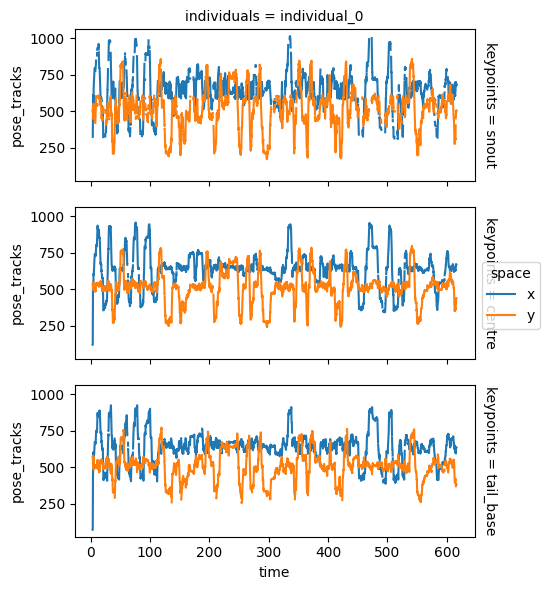

In [67]:
pose_tracks_sleap_3kps.plot.line(x="time", row="keypoints", col="individuals", aspect=2, size=2)

Now, we can plot the confidence scores for the `snout` keypoint over time.

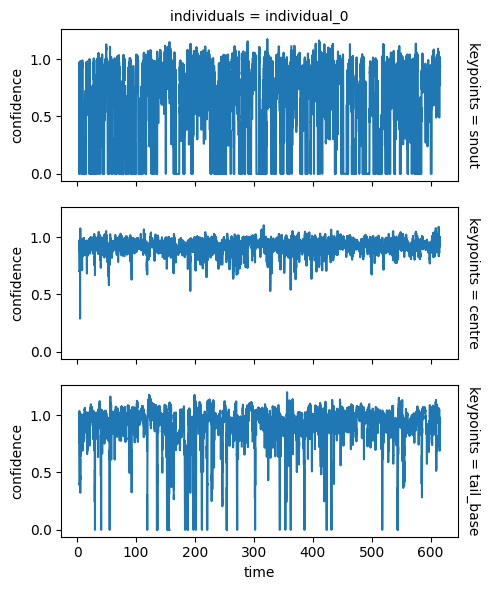

In [48]:
confidence_3kps = ds_sleap_video1.confidence.sel(keypoints=["snout", "centre", "tail_base"])
confidence_3kps.plot.line(x="time", row="keypoints", col="individuals", aspect=2, size=2)

**Exercise 3:**

- Work with the `ds_dlc_video1` dataset you created in **Exercise 1**.

- Get the `pose_tracks` data values for the 3 keypoints `["snout", "centre", "taibase"]` as `pose_tracks_dlc_3kps`.

- Get the `confidence` data values for the 3 keypoints `["snout", "centre", "taibase"]` as `confidence_dlc_3kps`.

- Plot the pose tracks and confidence scores for the 3 keypoints over time.

- What do you notice? How do they compare to the SLEAP pose tracks and confidence scores that we plotted above?

In [50]:
# Write your code here to get and plot the pose tracks for the 3 keypoints from the DLC dataset


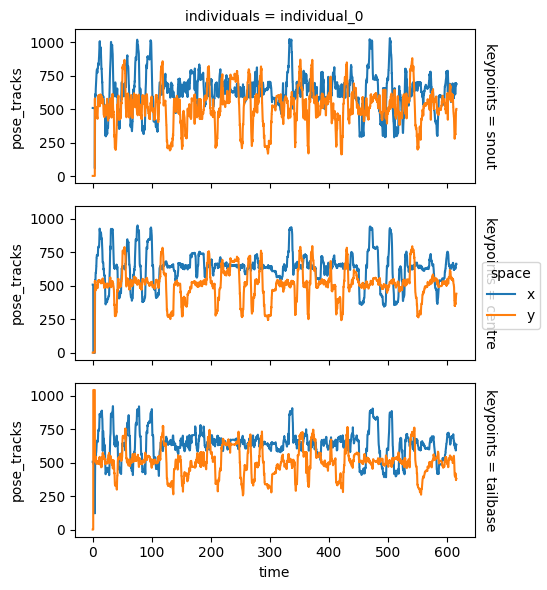

In [69]:
# Solution
pose_tracks_dlc_3kps = ds_dlc_video1.pose_tracks.sel(keypoints=["snout", "centre", "tailbase"])
pose_tracks_dlc_3kps.plot.line(x="time", row="keypoints", col="individuals", aspect=2, size=2)

In [ ]:
# Write your code here to get and plot the confidence scores for the 3 keypoints from the DLC dataset

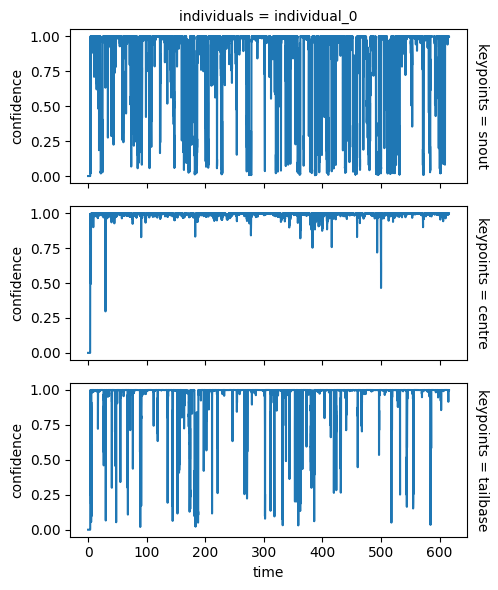

In [70]:
# Solution
confidence_dlc_3kps = ds_dlc_video1.confidence.sel(keypoints=["snout", "centre", "tailbase"])
confidence_dlc_3kps.plot.line(x="time", row="keypoints", col="individuals", aspect=2, size=2)

Check if your solution is correct by running the following cell:

In [74]:
necessary_keypoints = ["snout", "centre", "tailbase"]
necessary_data_arrays = {"pose_tracks_dlc_3kps": pose_tracks_dlc_3kps, "confidence_dlc_3kps": confidence_dlc_3kps}
for var_name, data_array in necessary_data_arrays.items():
    assert isinstance(data_array, xr.DataArray), f"{var_name} should exist and be an xarray DataArray"
    assert all(
        k in data_array.keypoints.values for k in necessary_keypoints
    ), f"{var_name} should have keypoints={necessary_keypoints}"


### B4. Plot keypoint trajectories over the video frame
First, we load the video frame.

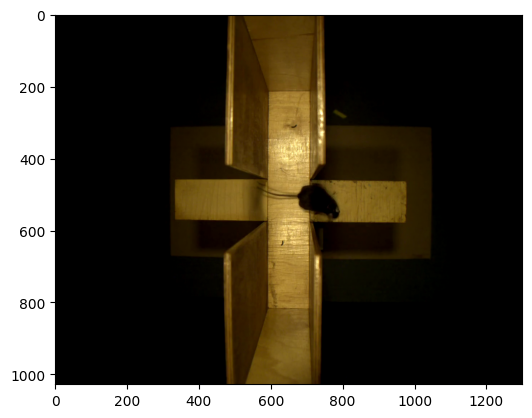

In [75]:
frame_img = plt.imread(video1_frame_file)
plt.imshow(frame_img)

Then we define a function to plot selected pose tracks over the video frame.

In [95]:
def plot_trajectory(
        ds: xr.Dataset,
        individual: str ="individual_0",
        keypoint: str = "tailbase",
        time_range: tuple = None,
        frame: np.ndarray = None,
):
    """Plot trajectory of a single keypoint for a given individual.
    
    Parameters
    ----------
    ds : xr.Dataset
        Dataset containing pose tracks.
    individual : str
        Name of the individual to plot.
    keypoint : str
        Name of the keypoint to plot.
    time_range : tuple
        Start and end time of the trajectory to plot. If None, the entire
        trajectory will be plotted.
    frame : np.ndarray
        Image to use as background. If None, the frame will not be shown.
    """

    fig, ax = plt.subplots(figsize=(7, 7))

    # Show the frame, if provided
    if frame is not None:
        ax.imshow(frame)

    # Select the appropriate data
    data = ds.pose_tracks.sel(individuals=individual, keypoints=keypoint)
    if time_range is not None:
        data = data.sel(time=slice(*time_range))
        
    plt.scatter(
        data.sel(space="x"), data.sel(space="y"), s=2, c=data.time, cmap="viridis"
    )
    plt.title(f"Trajectory of {individual} {keypoint}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(label="time (s)", orientation="horizontal")

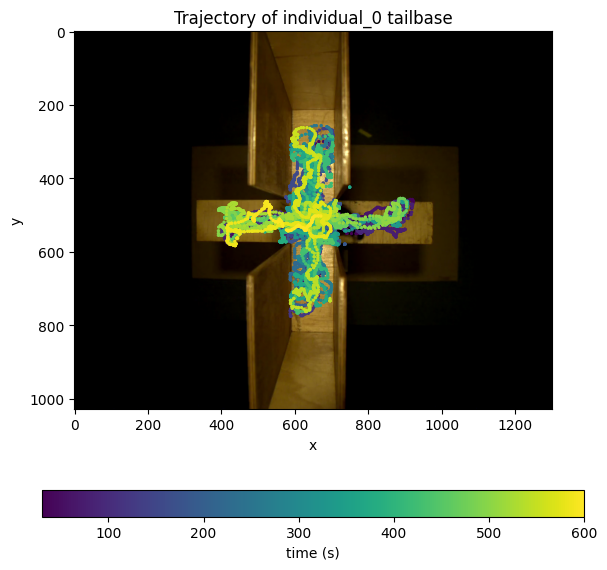

In [97]:
plot_trajectory(
    ds, individual="individual_0",
    keypoint="tailbase",
    frame=frame1_img,
    time_range=(30, 600)
)